CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
#!pip install captum

In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [3]:
# TODO: Enter your code here
df = pd.read_csv('hdb_price_prediction.csv')

# Training Data Set: Year 2019 and before
df_train = df[df['year'] <= 2019].copy()
# Validation Data Set: Year 2020
df_val = df[df['year'] == 2020].copy()
# Testing Data Set: Year 2021
df_test = df[df['year'] == 2021].copy()

# Dropping all Categorical Features
cat_col_names = ['month','town','flat_model_type','storey_range', 'full_address','nearest_stn','year']

df_train.drop(columns = cat_col_names, inplace=True)
df_val.drop(columns = cat_col_names, inplace=True)
df_test.drop(columns = cat_col_names, inplace=True)

print("Training Data:", df_train.shape)
print("Validation Data:", df_val.shape)
print("Testing Data:", df_test.shape) 

Training Data: (64057, 7)
Validation Data: (23313, 7)
Testing Data: (29057, 7)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159553 entries, 0 to 159552
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   month                   159553 non-null  int64  
 1   year                    159553 non-null  int64  
 2   town                    159553 non-null  object 
 3   full_address            159553 non-null  object 
 4   nearest_stn             159553 non-null  object 
 5   dist_to_nearest_stn     159553 non-null  float64
 6   dist_to_dhoby           159553 non-null  float64
 7   degree_centrality       159553 non-null  float64
 8   eigenvector_centrality  159553 non-null  float64
 9   flat_model_type         159553 non-null  object 
 10  remaining_lease_years   159553 non-null  float64
 11  floor_area_sqm          159553 non-null  float64
 12  storey_range            159553 non-null  object 
 13  resale_price            159553 non-null  float64
dtypes: float64(7), int64

In [28]:
# Creating Train, Val, Test data for train-test split
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

X_val = df_val.iloc[:,:-1]
y_val = df_val.iloc[:,-1]

X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [29]:
# Taking First 1000 Samples for Testing Data (Following Discussion Board)
X_test = X_test.sample(1000)
y_test = y_test.sample(1000)

> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [9]:
# TODO: Enter your code here
# Define a custom neural network class
class FeedForwardNN(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.lin1 = nn.Linear(no_features, no_hidden)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(no_hidden, no_hidden)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(no_hidden, no_hidden)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(no_hidden, no_labels)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

# Define the hyperparameters
no_features = X_train.shape[1] 
no_hidden = 5                  
no_labels = 1                  
batch_size = 50
num_epochs = 200
learning_rate = 0.001

model = FeedForwardNN(no_features,no_hidden,no_labels)
model.train()

FeedForwardNN(
  (lin1): Linear(in_features=6, out_features=5, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=5, out_features=5, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=5, out_features=5, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [67]:
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).view(-1, 1).float()

X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [12]:
import torch.optim as optim

def train(model_inp, num_epochs = num_epochs):
    
    # Define the Adam optimizer with a learning rate of 0.001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Defining the Criterion
    criterion = nn.MSELoss(reduction='sum')
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            
            # defining loss
            loss = criterion(outputs, labels)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # computing gradients
            loss.backward()
            
            # accumulating running loss
            running_loss += loss.item()
            
            # updated weights based on computed gradients
            optimizer.step()
            
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

In [16]:
# Training Model
train(model, num_epochs)

Epoch [1]/[200] running accumulative loss across all batches: 3696394080967680.000
Epoch [21]/[200] running accumulative loss across all batches: 343367403896832.000
Epoch [41]/[200] running accumulative loss across all batches: 291462707138304.000
Epoch [61]/[200] running accumulative loss across all batches: 277310160166912.000
Epoch [81]/[200] running accumulative loss across all batches: 266691192665472.000
Epoch [101]/[200] running accumulative loss across all batches: 259904591763712.000
Epoch [121]/[200] running accumulative loss across all batches: 255551647474304.000
Epoch [141]/[200] running accumulative loss across all batches: 252442742688512.000
Epoch [161]/[200] running accumulative loss across all batches: 250228542528768.000
Epoch [181]/[200] running accumulative loss across all batches: 248162996438528.000


In [68]:
# Evaluating Model
from sklearn.metrics import mean_squared_error

model.eval()
outputs = model(X_test_tensor)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test_tensor.detach().numpy()))

print('Model Error (Mean Squared Error): ', err)

Model Error (Mean Squared Error):  208936.14


In [35]:
# Captum Library Algorithms

ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)
saliency = Saliency(model)
input_x_gradient = InputXGradient(model)

ig_attr_test = ig.attribute(X_test_tensor, n_steps=50)
gs_attr_test = gs.attribute(X_test_tensor, X_train_tensor)
fa_attr_test = fa.attribute(X_test_tensor) 
saliency_attr_test = saliency.attribute(X_test_tensor)
input_x_gradient_attr_test = input_x_gradient.attribute(X_test_tensor)

/opt/anaconda3/envs/env_pytorch/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [31]:
# Getting Features into a list
feature_names = X_test.columns.tolist()
feature_names

['dist_to_nearest_stn',
 'dist_to_dhoby',
 'degree_centrality',
 'eigenvector_centrality',
 'remaining_lease_years',
 'floor_area_sqm']

In [40]:
order_legend = ['Integrated Gradients', 'GradientShap', 'FeatureAblation', 'Saliency', 'InputXGradient', 'Weights']

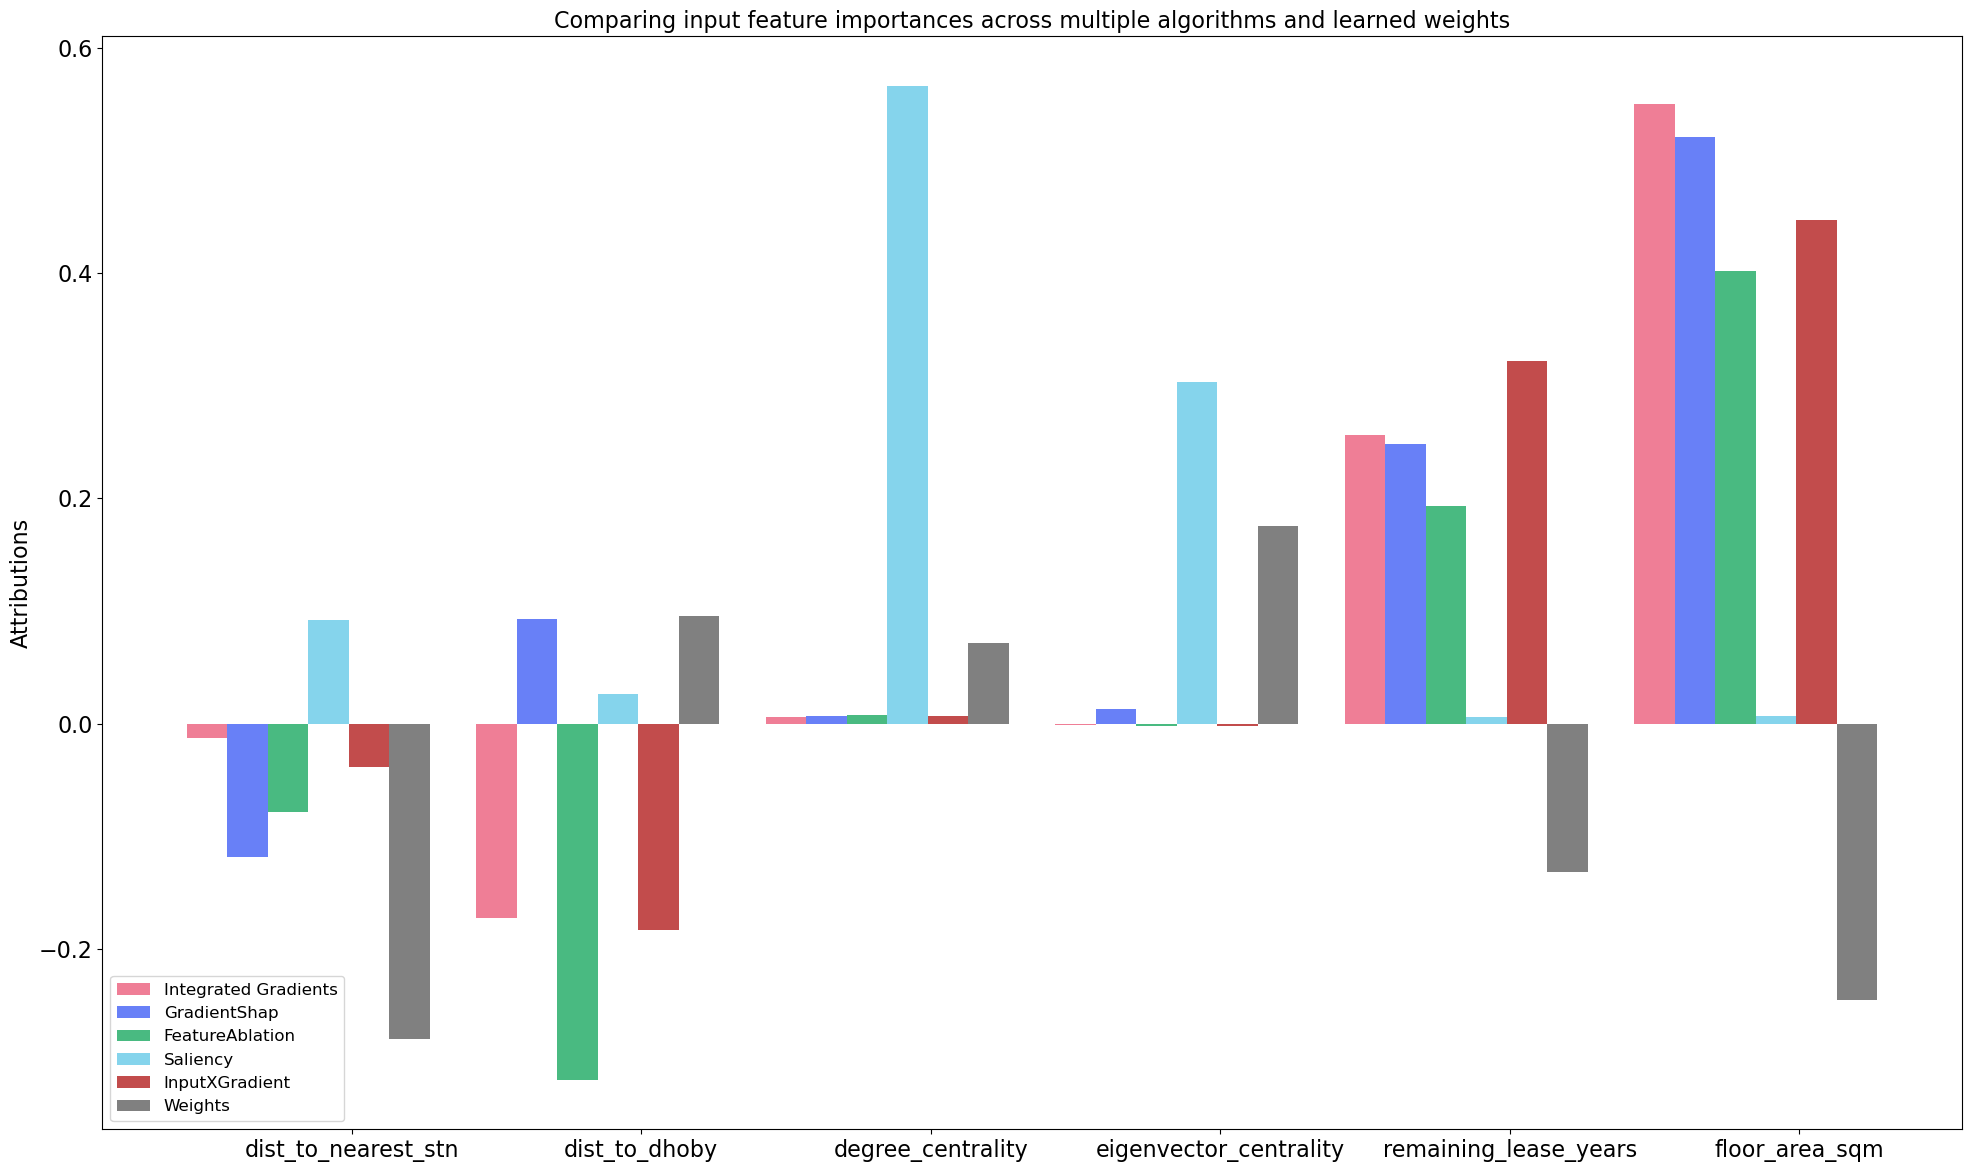

In [49]:
import matplotlib.pyplot as plt
# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

saliency_attr_test_sum = saliency_attr_test.detach().numpy().sum(0)
saliency_attr_test_norm_sum = saliency_attr_test_sum / np.linalg.norm(saliency_attr_test_sum, ord=1)

input_x_gradient_attr_test_sum = input_x_gradient_attr_test.detach().numpy().sum(0)
input_x_gradient_attr_test_norm_sum = input_x_gradient_attr_test_sum / np.linalg.norm(input_x_gradient_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = order_legend

plt.figure(figsize=(20, 12))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 2 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 3 * width, saliency_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 4 * width, input_x_gradient_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [56]:
from sklearn.preprocessing import StandardScaler
# TODO: Enter your code here

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the hyperparameters
no_features = X_train.shape[1] 
no_hidden = 5                  
no_labels = 1                  

scaled_model = FeedForwardNN(no_features,no_hidden,no_labels)
scaled_model.train()

FeedForwardNN(
  (lin1): Linear(in_features=6, out_features=5, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=5, out_features=5, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=5, out_features=5, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [64]:
X_train_scaled_tensor = torch.tensor(X_train_scaled).float()
X_test_scaled_tensor = torch.tensor(X_test_scaled).float()

In [60]:
# Training Scaled Model
train(scaled_model, num_epochs)

Epoch [1]/[200] running accumulative loss across all batches: 13858985105031168.000
Epoch [21]/[200] running accumulative loss across all batches: 13858985096511488.000
Epoch [41]/[200] running accumulative loss across all batches: 13858985100967936.000
Epoch [61]/[200] running accumulative loss across all batches: 13858985107193856.000
Epoch [81]/[200] running accumulative loss across all batches: 13858985080324096.000
Epoch [101]/[200] running accumulative loss across all batches: 13858985098870784.000
Epoch [121]/[200] running accumulative loss across all batches: 13858985085960192.000
Epoch [141]/[200] running accumulative loss across all batches: 13858985091334144.000
Epoch [161]/[200] running accumulative loss across all batches: 13858985075015680.000
Epoch [181]/[200] running accumulative loss across all batches: 13858985084649472.000


In [65]:
# Evaluation of Model and Error
scaled_model.eval()
outputs = model(X_test_scaled_tensor)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test_tensor.detach().numpy()))

print('Scaled Model Error (Mean Squared Error): ', err)

Scaled Model Error (Mean Squared Error):  620333.3


In [69]:
ig = IntegratedGradients(scaled_model)
gs = GradientShap(scaled_model)
fa = FeatureAblation(scaled_model)
saliency = Saliency(scaled_model)
input_x_gradient = InputXGradient(scaled_model)

ig_attr_test = ig.attribute(X_test_scaled_tensor, n_steps=50)
gs_attr_test = gs.attribute(X_test_scaled_tensor, X_train_tensor)
fa_attr_test = fa.attribute(X_test_scaled_tensor) 
saliency_attr_test = saliency.attribute(X_test_scaled_tensor)
input_x_gradient_attr_test = input_x_gradient.attribute(X_test_scaled_tensor)

/opt/anaconda3/envs/env_pytorch/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


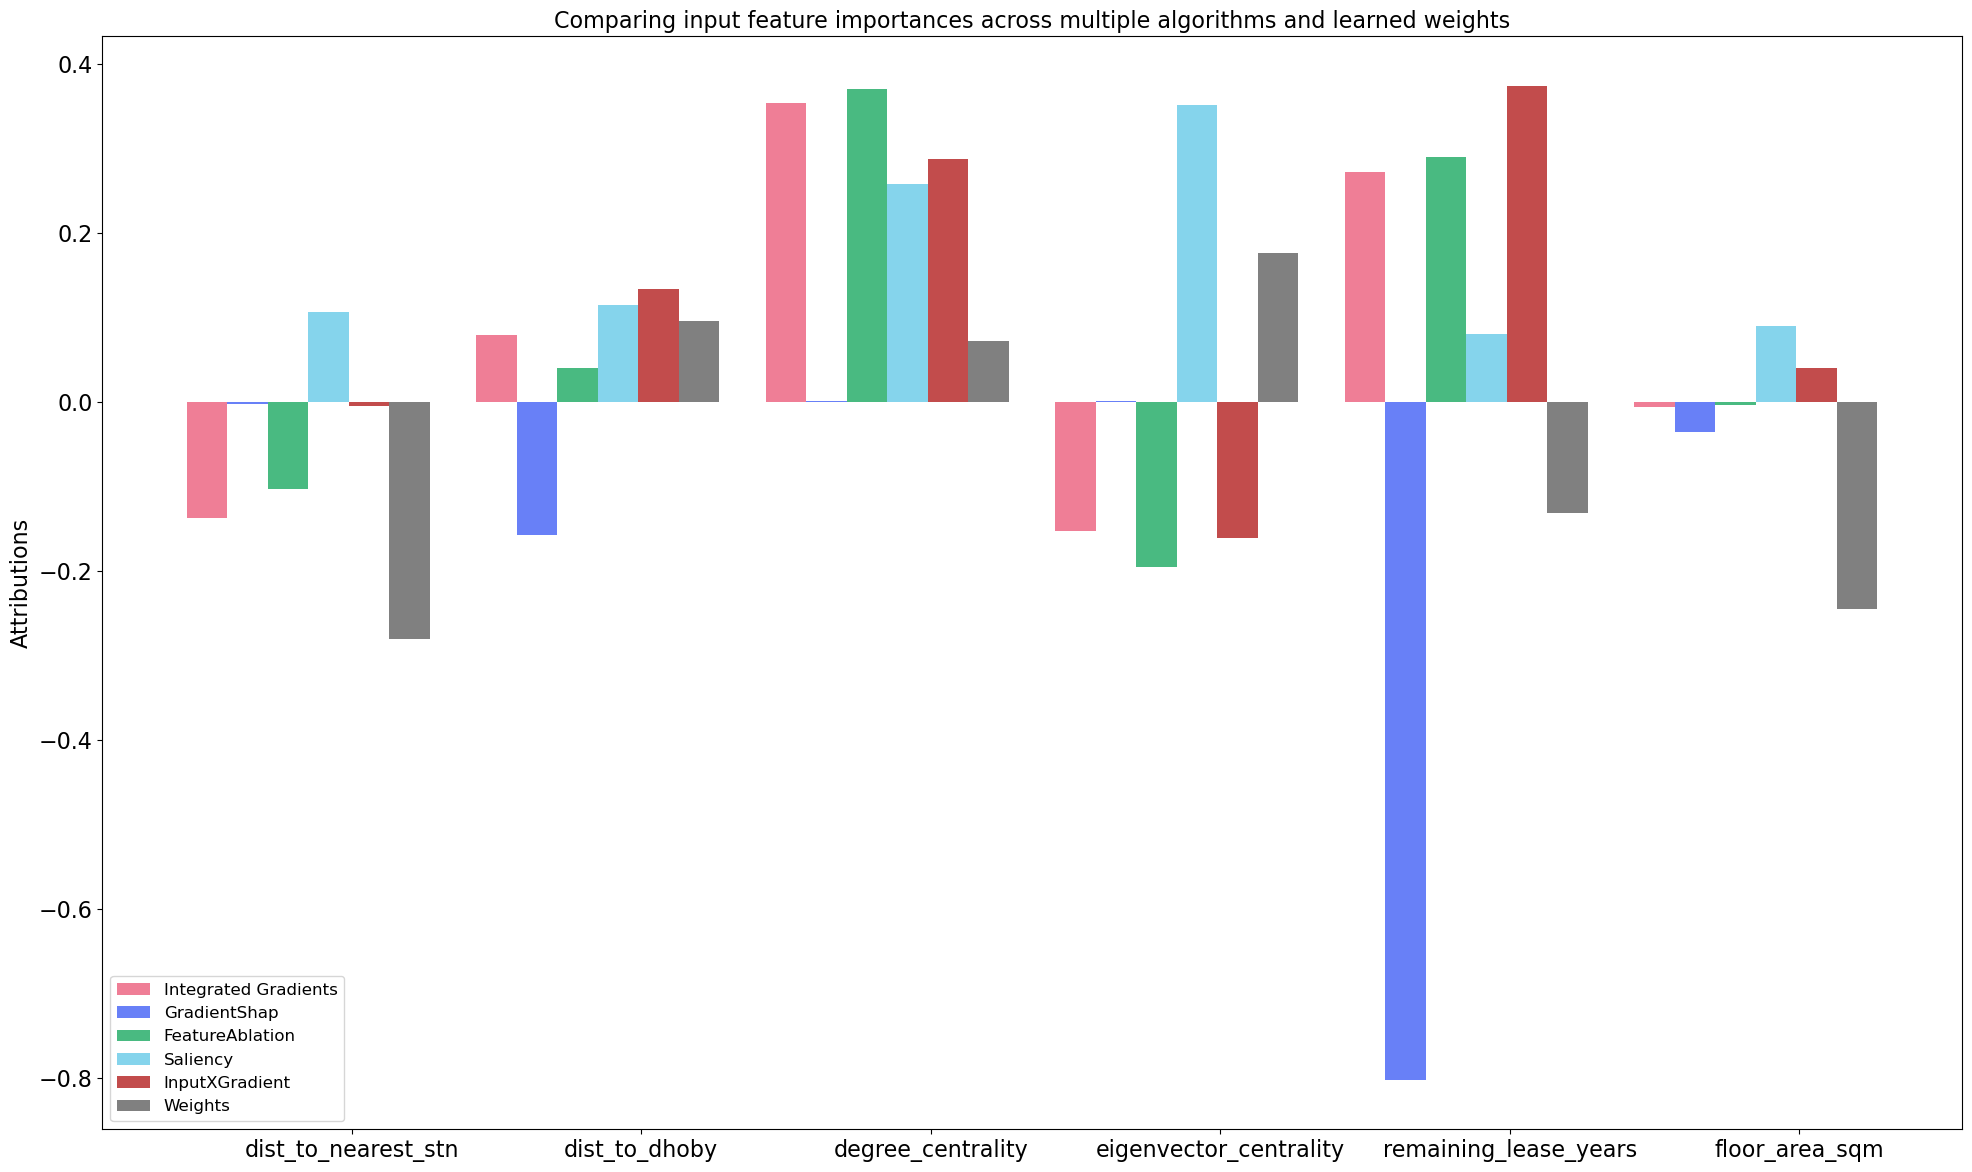

In [72]:
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

saliency_attr_test_sum = saliency_attr_test.detach().numpy().sum(0)
saliency_attr_test_norm_sum = saliency_attr_test_sum / np.linalg.norm(saliency_attr_test_sum, ord=1)

input_x_gradient_attr_test_sum = input_x_gradient_attr_test.detach().numpy().sum(0)
input_x_gradient_attr_test_norm_sum = input_x_gradient_attr_test_sum / np.linalg.norm(input_x_gradient_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = order_legend

plt.figure(figsize=(20, 12))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 2 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 3 * width, saliency_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 4 * width, input_x_gradient_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

Answer to Observations with respect to GradientShap
 - Based on the graphical results of Standard Scaler, most of the attributes are nearing zero for features dist_to_nearest_stn, degree_centrality and eigenvector_centrality. Furthermore, there is a negative deviation for features remaining_lease_years, floor_area_sqm and dist_to_dhoby.
 - This is very different compared to the graphical results without StandardScaler.

Explaination of this occurance
 - When using gradient-based attribution methods like GradientSHAP, the choice of the baseline is crucial. The baseline serves as a reference point to compute attributions by comparing the model's output when the input is at the baseline versus when it's at the actual input. Hence, the choice of the baseline can significantly affect the attribution results
 - In this case, when StandardScaler is used to standardise the features, the mean of each feature becomes 0, and the standard deviation becomes 1. This means that the "typical" input to the model is now centered around zero for each feature.
 - GradientSHAP uses a default baseline of zeros. This means that the baseline input has all feature values set to zero.
 - Thus, with standardized features and a default baseline of zeros, the GradientSHAP method will attribute importance based on how far the input data deviates from a baseline of zeros. This might lead to attributions that highlight features that deviate from zero in either the positive or negative direction which was shown in the graph above.
 - In order to obtain more meaningful insights, a custom baseline should be adopted

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores dissimilar to IG? (In my case for my graphs they are not similar)


\# TODO: \<
Saliency and Integrated Gradients are both "gradient-based" attribution methods, however they function differently. 

Some reasons why both Saliency and IG produce dissimilar scores:
1. Saliency is a local method that calculates the gradient of the model's output with respect to the input features at a specific input point. It measures how a small change in each feature at that point affects the model's prediction. However, Integrated Gradients takes a more holistic approach by calculating the integral of gradients along a path from a baseline to the actual input. It evaluates the cumulative impact of each feature's value change over this path.
2. Saliency might be more suitable to understand the influence of features at a single point, while IG can provide a more comprehensive view of feature importance over a range of inputs.

Hence, on the analysis of the hdb dataset, I feel that Integrated Gradients can give a more holistic overview in which feature has the highest impact on the prediction.
\>

> Why did Input x Gradients give the same attribution scores as IG?

\# TODO: \<
Input x Gradients and Integrated Gradients (IG) are both methods used for attributing feature importance to a model's prediction, by calculating the attribute score using gradients.

Some possible reasons for the similarity in attribute scores.
1. Both methods operate under the assumption that both models are approximately linear, and since the FeedForwardNN model that I used here is relatively linear in the vicinity of the input data point, the results produced might show some similarites in attribute scores.
2. The more similar results between IG and Input x Gradients occur in the second graph whenby the use of StandardScaler to scale the features down. There could be a possibility that this might lead to scores that are closer to each other.
\>